### Mobilnets Implementation

Testing the Mobilenet Segmentation Model

In [1]:
'''
Created on Aug 22, 2017

@author: jyarde
'''
from keras import backend as K
from keras.applications.mobilenet import MobileNet, relu6, DepthwiseConv2D
from keras.models import load_model, Model, Sequential
from keras.optimizers import RMSprop, Adam, SGD
from keras.engine.topology import Layer
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from keras.layers import Input, Activation, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2DTranspose, UpSampling2D
from keras.layers.core import Reshape, Dropout
from keras.layers.core import Lambda

from PIL import Image, ImageDraw, ImageFont, ImageOps
import tensorflow as tf

import cv2
from ImageProcessing import get_viewport
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from CameraOperations import show_grid

def run_prediction(x):
    prediction = model.predict(x, 1, True)
    return prediction


def read_config(config_file="./imagenet1000_clsid_to_human_array.json"):
    '''
      Read Configuration parameters from external file
    '''
    import json
    
    with open(config_file) as config_data:
        config = json.load(config_data)
    return config


def predict_with_mobilenet(image, model=None):
    if model is None:
        model = load_model('./mobilenet_1_0_224_tf_local.h5', 
                           custom_objects={'relu6': relu6, 'DepthwiseConv2D': DepthwiseConv2D})
    image_input = image/255.
    X = np.expand_dims(image_input, 0)
    prediction = model.predict(X, len(X), False)
    idx = np.argmax(prediction, 1)[0]
    return idx, prediction, model

def save_channels(prediction, classes=1000):
    max_prob = np.max(prediction)
    print("\n{: >3.0f} ".format(0), end="")
    for r in range(classes):
        prediction_img = prediction[0][:,:,r]*255/max_prob
        cv2.imwrite("./deconv/img{}.jpg".format(r), prediction_img)
        '''
        if r>0 and not r%10:
            term = "\n{: >3.0f} ".format(int(r/10))
        else:
            term = ","
        #print("{1: >6.2f}/{0: >4.2f}".format(np.max(prediction[0][:,:,r]),np.sum(prediction[0][:,:,r])), end=term)
        print("{0: >6.2f}".format(np.max(prediction[0][:,:,r])/np.sum(prediction[0][:,:,r])), end=term)
        '''

def deconv_layer(inputs, 
                 filters, 
                 alpha=1.0, 
                 kernel=(3, 3), 
                 strides=(2, 2), 
                 block_id=1, 
                 activation=None, 
                 use_bias=True):
    '''
        Deconvolutional layers
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = Conv2DTranspose(filters, kernel,
               padding='valid',
               use_bias=use_bias,
               strides=strides,
               name='deconv_%d' % block_id,
               kernel_initializer='he_normal',
               bias_initializer='zeros')(inputs)
    #x = BatchNormalization(axis=channel_axis, name='deconv_bn_%d' % block_id)(x)
    if activation is None:
        return Activation(relu6, name='deconv_relu_%d' % block_id)(x)
    else:
        return activation(x)

    
def conv_layer(inputs, 
               filters, 
               alpha=1.0, 
               kernel=(3, 3), 
               strides=(1, 1), 
               block_id=1, 
               activation=None, 
               use_bias=False,
               padding='valid'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = Conv2D(filters, kernel,
               padding=padding,
               use_bias=use_bias,
               strides=strides,
               name='t_conv_%d' % block_id,
               kernel_initializer='he_normal',
               bias_initializer='zeros')(inputs)
    x = BatchNormalization(axis=channel_axis, name='t_conv_bn_%d' % block_id)(x)
    if activation is None:
        return Activation(relu6, name='t_conv_relu_%d' % block_id)(x)
    else:
        return activation(x)

class CustomReshape(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CustomReshape, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        super(CustomReshape, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return tf.reshape(x, [-1, self.output_dim]) #np.reshape(x, (-1, 14)) 

    def compute_output_shape(self, input_shape):
        print("CustomReshape", input_shape)
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim}
        base_config = super(CustomReshape, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class BilinearUpSampling2D(Layer):

    def __init__(self, output_dim, scale_factor, **kwargs):
        self.output_dim   = output_dim
        self.scale_factor = scale_factor
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        super(BilinearUpSampling2D, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        input_size = tf.shape(x)
        size = (self.scale_factor*input_size[1], self.scale_factor*input_size[2])
        new_size = tf.convert_to_tensor(size, dtype=tf.int32)
        return tf.image.resize_images(x, new_size)
        #return tf.reshape(x, [-1, self.output_dim]) 

    def compute_output_shape(self, input_shape):
        print("BilinearUpSampling2D", input_shape)
        return input_shape[:-1] + (self.output_dim,)

    def get_config(self):
        config = {'output_dim': self.output_dim, 'scale_factor': self.scale_factor}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def generate_magic_kernel(classes=15, channels=15):
    magic_kernel = np.array([[0.25,0.75,0.75,0.25],
                         [0.25,0.75,0.75,0.25],
                         [0.25,0.75,0.75,0.25],
                         [0.25,0.75,0.75,0.25]])
    kernel = []
    for c in range(channels):
        kernel_channel
        for cl in range(classes):
            kernel_channel.append(magic_kernel)
        kernel.append(kernel_channel)
    return np.array(kernel)

def preprocess_image(image, normalize=False, pad=0):
    '''
    Normalize is divide by 255.
    pad is pad to multiples of 'pad'
    '''
    w = image.shape[1]
    h = image.shape[0]
    img = None
    if pad > 0:
        w_pad = pad - (w % pad)
        h_pad = pad - (h % pad)
        img = np.lib.pad(image, ((h_pad,0),(w_pad,0),(0,0)), 'constant', constant_values=(0,0))
    #else:
    #    img = np.asarray(image)
    if normalize:
        img = img/255.
    return img


def load_img(file, normalize=False, pad=0):
    '''
     Load images and always convert to RGB representation
     If 'normalize' is True, then divide by 255.
     If 'pad' is more than 0, pad the image to a multiple of the provided number
    '''
    image = Image.open(file)
    if image.mode is not 'RGB':
        image = image.convert('RGB')
    return preprocess_image(np.asarray(image), normalize, pad)


def pad_image(image, thickness=(1,1), padding=(1,1)):
    return np.lib.pad(image, thickness, 'constant', constant_values=padding)


def predict_with_model(image, model=None):
    X = None
    #Expand if a single image
    if (len(image.shape) < 4):
        X = np.expand_dims(image, 0)
    else:
        X = image
    prediction = model.predict(X, len(X), True)
    print("Output Shape: ", prediction.shape)
    idx = np.argmax(prediction)
    return idx, prediction


def prediction_heatmaps(image, model, classes=2):
    highest, pred = predict_with_model(image, model)
    #heatmap = np.concatenate([pad_image(pred[:,:,c], thickness=(1,1)) for c in range(classes)], axis=1)
    print("Prediction Shape:", pred.shape)
    heatmaps = []
    for result in pred:
        heatmap = np.concatenate([result[:,:,c] for c in range(classes)], axis=1)
        heatmaps.append(heatmap)
    return np.array(heatmaps)

'''
conv_model = Model(segmenter.input, segmenter.layers[-6].output)
'''

def extract_heatmap_class(heatmap, classid, classes=2):
    frame_width = heatmap.shape[1]/classes
    start = int(classid*frame_width)
    end   = int(start + frame_width)
    return heatmap[:,start:end]


def image_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    r = clahe.apply(image[:,:,0])
    g = clahe.apply(image[:,:,1])
    b = clahe.apply(image[:,:,2])
    return np.stack([r,g,b], -1)


from ImageProcessing import weighted_img

def apply_mask(img, mask, color=(255,0,255), threshold=0.05):
    threshold_img = np.copy(mask)
    threshold_img[mask <= threshold] = 0
    stacked_img = np.stack((threshold_img,)*3, -1)
    for c in range(3):
        stacked_img[:,:,c] = stacked_img[:,:,c] * color[c]
    #shape = (img.shape[1],img.shape[0])
    #stacked_img = cv2.resize(stacked_img, shape, interpolation=cv2.INTER_AREA)
    #stacked_img = stacked_img * 255
    masked_img = weighted_img(img.astype('int16'), stacked_img.astype('int16'), α=0.5, β=0.5, λ=0.)
    return masked_img

    
def process_image(img, fcn, targets=[0,1], pad=0, equalize=False, is_file=True, mask_img=False):
    '''
    Show heatmaps for image targets from deconvolutional model and pure fully convolutional model
    targets is a list of class ids to show
    '''
    if is_file:
        img = load_img(img_file, normalize=False, pad=pad)
    
    if equalize:
        img = image_clahe(img)
        
    target_fcn = None
    
    heatmaps = prediction_heatmaps(img/255., fcn)
    names = [class_names[n] for n in targets]
    #names.insert(0, "Source")
    for h in range(len(heatmaps)):
        heatmap = heatmaps[h]
        if mask_img:
            target_fcn = [ apply_mask(img[h], extract_heatmap_class(heatmap, c) ) for c in targets]
            show_grid(target_fcn, names)
        else:
            target_fcn = [extract_heatmap_class(heatmap, c) for c in targets]
            show_grid(target_fcn, names, cmap_mono="hot")
    
    return heatmaps


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load the saved model

In [ ]:

input_size = (256,256)
fcn_size   = (512,512)
classes    = 2
#fcn_model_file = "./training/fcn_weights_44-0.971-0.029.hdf5"
fcn_model_file = "./training/fcn_weights_37-0.983-0.020.hdf5"
class_names = ["background", "road"]


fcn_model = load_model(fcn_model_file, 
                       custom_objects={'relu6': relu6, 
                                       'DepthwiseConv2D': DepthwiseConv2D, 
                                       'CustomReshape': CustomReshape, 
                                       'BilinearUpSampling2D': BilinearUpSampling2D})


fcn_model.summary()


### Visualize model

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils import plot_model
plot_model(fcn_model, to_file='/home/jyarde/mobilenet_model.png', show_shapes=True)

SVG(model_to_dot(fcn_model).create(prog='dot', format='svg'))

### Model Testing

In [ ]:
pad_len = 32

ask_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_training/output/1/um_road_000030.png"
img_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/testing/image_2/um_000030.png"

img_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/testing/image_2/um_000040.png"
mask_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_training/output/1/um_road_000040.png"

img_file = "/home/jyarde/Pictures/PO01RoadMain.jpeg"
img_file = "/home/jyarde/Pictures/N4_Dromad-Roosky_(bright_enhance_filter).jpg"

pad_len=32
img = load_img(img_file, normalize=False, pad=pad_len)
img_mask = load_img(mask_file, normalize=False, pad=pad_len)
plt.imshow(img_mask)

fcn_output = process_image(img_file, fcn_model, targets=[0,1], pad=pad_len, equalize=False)
#fcn_output.append(img_mask)
#show_grid(fcn_output, ["Image", "Background", "Road", "Mask"])
print()

In [ ]:
img_mask[:,:,:][300,600]

In [ ]:
from ImageProcessing import weighted_img

#masked_img = weighted_img(img, img_mask, α=0.8, β=1., λ=0.)
#show_grid([img, masked_img], ["Source", "Target"])

threshold = 0.55
threshold_img = np.copy(fcn_output[2])
threshold_img[fcn_output[2] <= threshold] = 0

stacked_img = np.stack((threshold_img,)*3, -1)

stacked_img[:,:,0] = 0
stacked_img[:,:,2] = 0
shape = (img.shape[1],img.shape[0])
stacked_img = cv2.resize(stacked_img, shape, interpolation=cv2.INTER_AREA)
stacked_img = stacked_img * 255

masked_img = weighted_img(img_mask.astype('int16'), stacked_img.astype('int16'), α=1., β=0.8, λ=0.)
show_grid([img, masked_img], ["Source", "Target"])

masked_img = weighted_img(img.astype('uint16'), stacked_img.astype('uint16'), α=0.5, β=0.5, λ=0.0)
show_grid([img, masked_img], ["Source", "Target"])

np.max(masked_img)

### Apply to Video

In [ ]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import matplotlib.image as mpimg

idx=0
cache = []

def save_frames(image):
    global idx
    mpimg.imsave("debug_images/{0}_mpl.png".format(idx), image)
    cache.append(image)
    idx = idx + 1
    return image

clip_output = "./annotated_project_video.mp4" 
clip_handle = VideoFileClip("test_video.mp4", audio=False)
img_clip = clip_handle.fl_image(save_frames) 
img_clip.write_videofile(clip_output, audio=False)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw, ImageFont, ImageOps
import numpy as np

imfile = "test/test1.png"
imfile = "debug_images/{0}_mpl.jpg".format(0)
imfile = "debug_images/{0}_mpl.png".format(0)

img = cache[0]
img_m = mpimg.imread(imfile)
img_c = cv2.imread(imfile)
img_p = Image.open(imfile)
a = plt.imshow(img_m)

#np.asarray(img_p, 'float32')


In [ ]:
fcn_output = process_frame(img, fcn_model, targets=[0,1], pad=32, threshold=0.05) 
#process_image(img_file, fcn_model, None, targets=[0,1], pad=pad_len)
show_grid([img, fcn_output], ["Image", "Road"])


In [ ]:
from ImageProcessing import image_brightness

def image_preprocessing(image):
    img = image.astype("uint8")
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def image_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    r = clahe.apply(image[:,:,0])
    g = clahe.apply(image[:,:,1])
    b = clahe.apply(image[:,:,2])
    
    return np.stack([r,g,b], -1)

show_grid( 
    [img, 
     image_brightness(img, phi=5, theta=1, maxIntensity=255.0), 
     img,
     process_frame(img, fcn_model, targets=[0,1], pad=32, threshold=0.55)], 
    ["source", "brightness", "clahe", "Masked"] )

show_grid( 
    [img, image_clahe(image_brightness(img, phi=5, theta=1, maxIntensity=255.0)), image_clahe(img)], 
    ["source", "brightness", "clahe"] )

#show_grid( [image_brightness(img, phi=phi) for phi in range(1,10)], [i for i in range(1,10)])

### Bulk Testing

In [ ]:

from CameraOperations import load_images_from_folder

folder = "./data/data_road/testing/image_2"
image_batch = load_images_from_folder(folder, images=None, name_pattern="um_00001*.png", pad=32, RGB=True)
show_grid(image_batch, [i for i in range(len(image_batch))])
a = process_image(image_batch, fcn_model, is_file=False, mask_img=True)


In [ ]:
image_batch = load_images_from_folder(folder, images=None, name_pattern="um_00002*.png", pad=32, RGB=True)
show_grid(image_batch, [i for i in range(len(image_batch))])
a = process_image(image_batch, fcn_model, is_file=False, mask_img=True)


In [ ]:
image_batch = load_images_from_folder(folder, images=None, name_pattern="um_00003*.png", pad=32, RGB=True)
show_grid(image_batch, [i for i in range(len(image_batch))])
a = process_image(image_batch, fcn_model, is_file=False, mask_img=True)


In [ ]:
image_batch = load_images_from_folder(folder, images=None, name_pattern="um_00004*.png", pad=32, RGB=True)
show_grid(image_batch, [i for i in range(len(image_batch))])
a = process_image(image_batch, fcn_model, is_file=False, mask_img=True)


# Image Data Generator Testing

In [3]:
from fcnprocessing import ImageDataGenerator

# we create two instances with the same arguments
shift = 0.2
classes = 3
data_gen_args = dict(rescale=1./255,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='constant',
                     cval=0,
                     width_shift_range=shift,
                     data_format="channels_last",
                     num_classes=classes)
'''
                     height_shift_range=shift, 
                     brightness=5,
                     channel_shift_range=32,
                     rotation_range=0)
                     shear_range=0.2,
                     zoom_range=0.2,
'''

image_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
root = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/kitti_road/"
#root = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_15/"
image_dir = root+"input/"
mask_dir  = root+"output/"
multiplier = 4
batch = 8

image_generator = image_datagen.flow_from_directory(image_dir,
                                                    class_mode='sparse_mask',
                                                    batch_size=batch,
                                                    seed=seed,
                                                    target_size=(371, 1227))


Found 289 images belonging to 1 classes.


In [4]:
labels = [i for i in range(8)]
x_batch, y_batch = image_generator.next()
#show_grid(x_batch, labels)
#show_grid(y_batch[:,:,:,1], labels)

masked_imgs = []
road_masks = y_batch[:,:,:,2]
for i in labels:
    img = apply_mask(x_batch[i]*255, road_masks[i], color=(255,0,255), threshold=0.05)
    masked_imgs.append(img)

#show_grid(masked_imgs, labels)


Processing 132 : 1/145.png
Processing 265 : 1/244.png
Processing 230 : 1/17.png
Processing 62 : 1/175.png
Processing 110 : 1/289.png
Processing 27 : 1/109.png
Processing 91 : 1/83.png
Processing 187 : 1/239.png


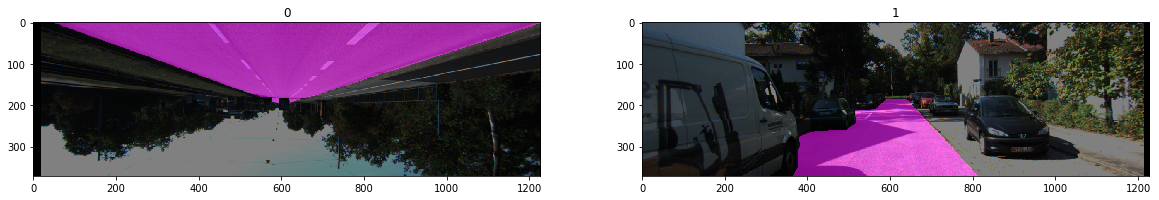

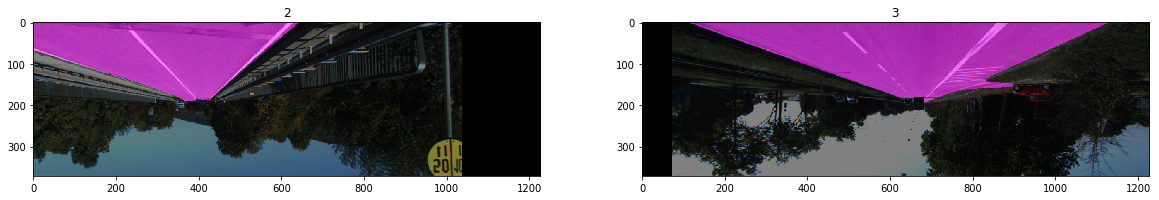

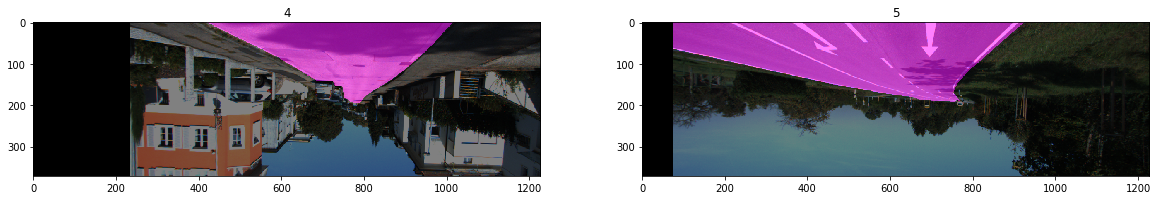

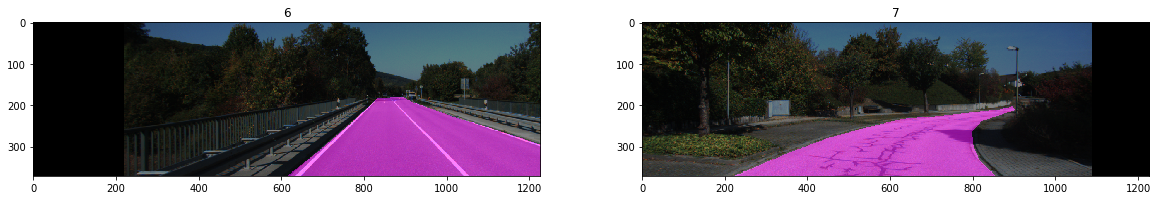

<Figure size 1440x720 with 0 Axes>

In [5]:
i=2*2
for i in range(0,10,2):
    show_grid(masked_imgs[i:i+2], labels[i:i+2])
